In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

slim = tf.contrib.slim
ds = tf.contrib.distributions

from universal_divergence import estimate
from utils import nn_l2_mean

from functools import reduce
from operator import mul

import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Populating the interactive namespace from numpy and matplotlib



### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [2]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [3]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-5,4,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [4]:
# params = dict(
#     batch_size=512,
#     disc_learning_rate=1e-4,
#     gen_learning_rate=1e-4,
#     beta1=0.5,
#     epsilon=1e-8,
#     max_iter=8000,
#     viz_every=2000,
#     z_dim=256,
#     x_dim=2,
# )
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=2000,
    z_dim=256,
    x_dim=2,
    optimizer='rmsprop', # rmsprop sgd sga
)

## Construct model and training ops

In [5]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# Vanilla discriminator update
# d_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
# Vanilla generator update
# g_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)

## Train

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/20001 [00:00<?, ?it/s]

0


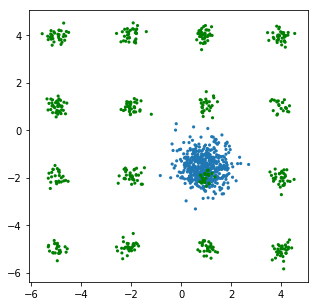

 10%|▉         | 1997/20001 [01:12<03:32, 84.83it/s] 

2000


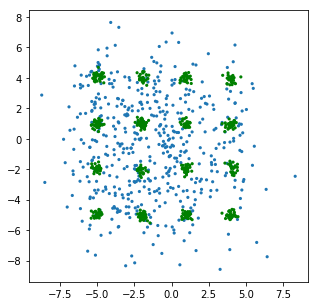

 20%|█▉        | 3999/20001 [02:23<02:50, 93.97it/s]

4000


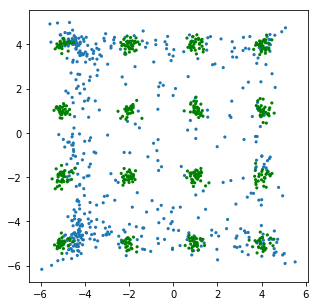

 30%|██▉       | 5997/20001 [03:34<02:36, 89.23it/s]

6000


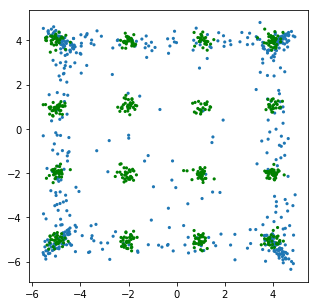

 40%|███▉      | 7993/20001 [04:44<02:11, 91.24it/s]

8000


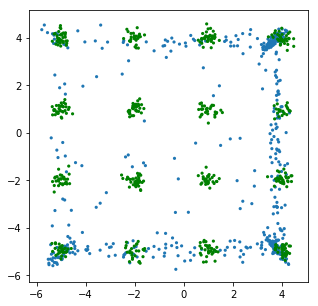

 50%|████▉     | 9998/20001 [05:53<01:53, 88.20it/s]

10000


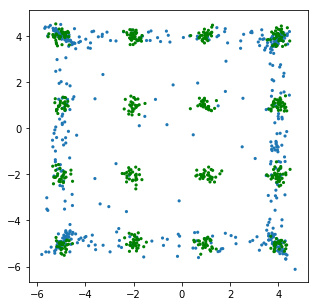

 60%|█████▉    | 11999/20001 [07:02<01:31, 87.04it/s]

12000


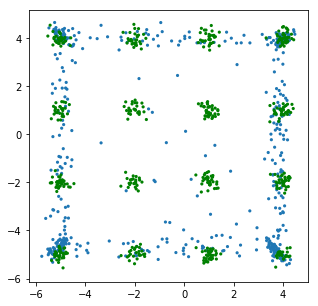

 70%|██████▉   | 13996/20001 [08:12<01:05, 91.98it/s]

14000


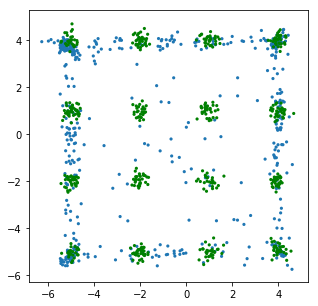

 80%|███████▉  | 15997/20001 [09:22<00:43, 92.03it/s]

16000


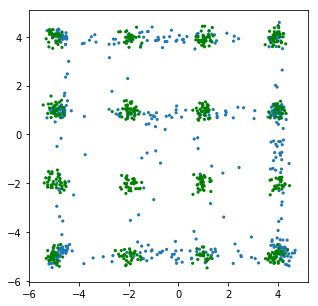

 90%|████████▉ | 17998/20001 [10:32<00:21, 92.79it/s]

18000


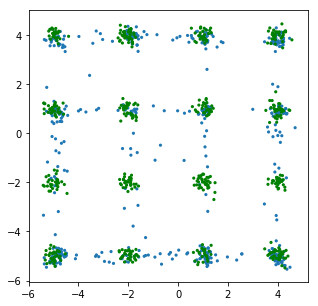

100%|█████████▉| 19995/20001 [11:43<00:00, 91.04it/s]

20000


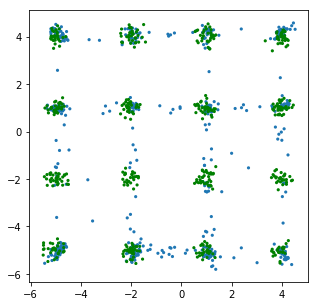

100%|██████████| 20001/20001 [11:48<00:00, 28.25it/s]


In [7]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']

nn_every = 200
y_ref = sess.run(data)
nn_dist = []
nn_kl =[]

for i in tqdm(range(params['max_iter']+1)):
    f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    fs.append(f)
    if (i) % viz_every == 0:
        print(i)
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
#         axis('off')
        show()
    
    if (i) % nn_every == 0:
        x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
        l2nn = nn_l2_mean(x,y_ref)
        kl =estimate(x, y_ref,k=1)
        nn_dist.append(l2nn)
        nn_kl.append(kl)    

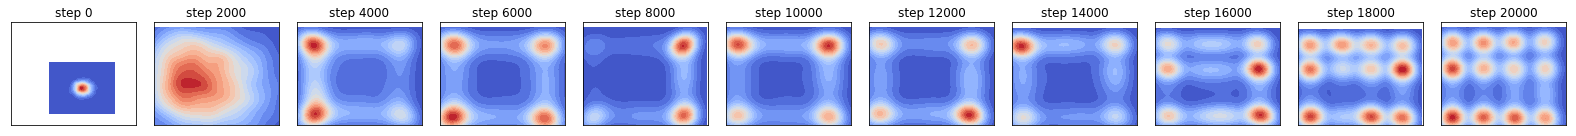

In [8]:
# np_samples_ = np_samples[::1]
# cols = len(np_samples_)
# bg_color  = sns.color_palette('Greens', n_colors=256)[0]
# figure(figsize=(2*cols, 2))
# for i, samps in enumerate(np_samples_):
#     if i == 0:
#         ax = subplot(1,cols,1)
#     else:
#         subplot(1,cols,i+1, sharex=ax, sharey=ax)
#     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
#     ax2.set_axis_bgcolor(bg_color)
#     xticks([]); yticks([])
#     title('step %d'%(i*viz_every))
# gcf().tight_layout()

np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
#     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=.40, n_levels=20, clip=[[-6,6]]*2)

#     ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
gcf().tight_layout()

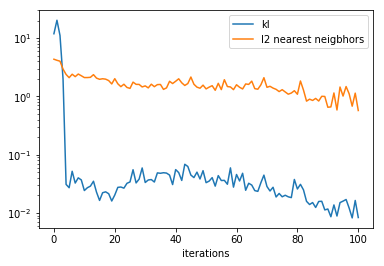

In [9]:
plt.semilogy(nn_dist)
plt.semilogy(nn_kl)
plt.legend(['kl','l2 nearest neigbhors'])
xlabel('iterations')
plt.show()

In [10]:
np.save('plot_sgd_kl',nn_kl)
np.save('plot_sgd_nn',nn_dist)